# **Solving the LASSO problem**
$$\min \frac{1}{2} \| {\bf b} - {\bf A} {\bf x} ||_2^2 + \gamma ||\bf x||_1$$

$f({\bf x})=  \frac{1}{2} \| {\bf b} - {\bf A} {\bf x} ||_2^2$

$r(\bf x) = ||\bf x||_1$

where ${\bf A}$ is a sparse induced transform, e.g., DCT or wavelets


${\bf A} {\bf x} = vec({\bf D} {\bf X} {\bf D}^T) = ({\bf D} \otimes {\bf D}) {\bf x}$


In [216]:
# import numpy and scipy for array operations and image processing
import numpy as np
import scipy.io
import scipy.misc
import scipy.fftpack
import matplotlib.pyplot as plt
import imageio
from PIL import Image
import cvxpy as cp

<ipython-input-217-a38482df2eeb>:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread("https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png")


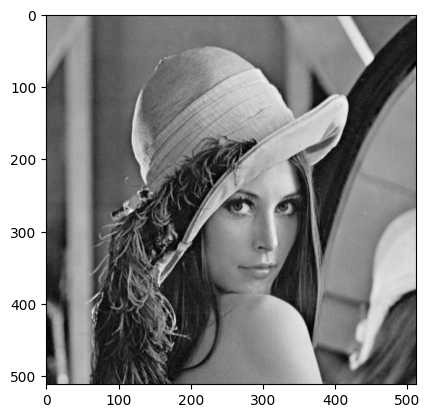

In [217]:
# load the Lena image from a URL using imageio
im = imageio.imread("https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png")

# set the random seed for reproducibility
np.random.seed(0)

# resize the image to 512 x 512
im = Image.fromarray(im).resize((512,512))
im = im.convert("L")
im = np.array(im)/256
# display the image
plt.imshow(im, cmap='gray')
plt.show()

# add Gaussian noise to the image (optional, uncomment to use)
# im = im + np.random.normal(0, 0.001, im.shape)
# convert the image to double precision
im = im.astype(np.double)

# get the image size
im_size = im.shape

# DCT
D = scipy.fftpack.dct(np.eye(im_size[0]), norm='ortho')

Ydct = D @ im @ D.T

gammamax = np.max(np.abs(Ydct))
gamma = 0.001 * gammamax

In [218]:
# define a class A with two methods that perform the 2D DCT and its transpose
class A:
  def x(self, x):
    # reshape x to the size of the image
    x = x.reshape(im.shape)
    # perform the 2D DCT
    #return scipy.fftpack.dct(x, axis=0, norm="ortho") @ scipy.fftpack.dct(x, axis=1, norm="ortho").T
    return D @ x @ D.T
  def T(self, x):
    # reshape x to the size of the image
    x = x.reshape(im.shape)
    # perform the 2D DCT transpose
    #return scipy.fftpack.idct(x, axis=0, norm="ortho") @ scipy.fftpack.idct(x, axis=1, norm="ortho").T
    return D.T @ x @ D
# create an instance of A
A = A()

The primal LASSO problem can be solved by CVX

However, don't use CVX or CVXPY for images with image size larger than 64 x 64

In [219]:
if im.shape[0]<64:
  # create a cvxpy variable for X
  X = cp.Variable(im.shape)
  # define the objective function
  Yx = D @ X @ D.T # 2D iDCT to coefficients X
  f = cp.sum_squares(im - Yx) + gamma * cp.norm(X, 1)
  # create a cvxpy problem to minimize f
  prob = cp.Problem(cp.Minimize(f))
  # solve the problem
  prob.solve()
  # store the results
  h = {}
  h["x_cvx"] = X.value
  h["p_cvx"] = prob.value
  # display the image
  plt.imshow(Yx.value, cmap="gray")
  plt.show()

  plt.imshow(np.log10(np.abs(X.value)), cmap="gray")
  plt.show()

Reformulate the LASSO problem
$$\min \quad \frac{1}{2} \| {\bf b} - {\bf z} ||_2^2 + \gamma ||{\bf x}||_1 \quad \quad
\text{s.t.} \; \;{\bf z} = {\bf A} {\bf x}$$
Lagrangian function
$$L(x,\nu) =  \frac{1}{2} \| {\bf b} - {\bf z} ||_2^2 + \gamma ||{\bf x}||_1  + \nu^T ({\bf z} - {\bf A} {\bf x})
$$

Dual function is built from the convex conjugate functions of $f$ and $r$

$$g(\nu) = -f^{\star}(-\nu) - r^{\star}({\bf A}^T \nu)$$

where

$f({\bf z}) = \frac{1}{2}\|{\bf b} - {\bf z}\|_2^2$  has conjugate function $f^{\star}({\nu}) = \frac{1}{2} \nu^T \nu + {\bf b}^T \nu$,

$r(\bf x) = ||\bf x||_1$ has conjugate function $r^{\star}({\nu}) = \begin{cases} 0  \quad & \|\nu\|_{\infty}  \le \gamma \\
\infty \quad & \text{otherwise} \end{cases}$

Dual problem is a constrained QP


$$\max \quad \frac{-1}{2} \nu^T \nu + {\bf b}^T \nu
\quad \text{s.t.} \quad \|{\bf A}^T \nu\|_{\infty} \le \gamma$$

which can be solved using the quadprog toolbox

$$\begin{array}{ll}
\min & \frac{1}{2} \nu^T \nu - {\bf b}^T \nu \\
\text{s.t.} & \begin{pmatrix}{\bf A}^T\\ -{\bf A}^T \end{pmatrix} \nu  \le \gamma  
\end{array}$$

Note that the explicit form of the linear operator $\bf A$ often is often very big,
e.g., $\bf A = \bf D \otimes \bf D$ is Kronecker product of the left and right linear tranform operator of the image.


We can solve the dual problem by ADMM


$$\min \quad \frac{1}{2} \nu^T \nu - {\bf b}^T \nu + \mathcal{i}(\| {\bf u} \|_{\infty} \le \gamma)\\
\quad \text{s.t.} \quad {\bf A}^T \nu = {\bf w}$$

Update $\nu$

$$\begin{array}{ll}
\nu &= \arg\min_\nu \quad \frac{1}{2} \nu^T \nu - {\bf b}^T \nu + \frac{\lambda}{2} \|{\bf A}^T \nu -{\bf w}+ {\bf u}\|_2^2 \\
&= \frac{{\bf b} + \lambda {\bf A}({\bf w} - {\bf u})}{1 + \lambda}
\end{array}
$$

Update ${\bf w}$
$$\begin{array}{ll}
{\bf w} &= \arg\min_w \quad   \mathcal{i}(\|{\bf w}\|_{\infty} \le \gamma) + \frac{\lambda}{2} \|{\bf A}^T \nu + {\bf u} - w\|_2^2 \\
&=  proj_{\gamma}({\bf A}^T \nu + {\bf u})  \\
&= \begin{cases}
t_{i,j} & |t_{i,j}| \le \gamma\\
\gamma sign(t_{i,j}) & |t_{i,j}| > \gamma
\end{cases}
\end{array}
$$
where ${\bf t} = {\bf A}^T \nu + {\bf u}$

Update $\bf u$
$$\bf u = \bf u  + {\bf A}^T \nu - \bf w$$

In [220]:
def solver_lasso_dual(y,A,gamma,lambda_):
  # ADMM algorithm for the dual problem
  # max 1/2 x^T x - b^T x
  # s.t.  ||A^T x || <= gamma
  rho = 1 / lambda_

  n = y.shape
  # x = zeros(n);
  u = np.zeros(n)
  z = A.T(y)

  ix = np.abs(z) > gamma
  z[ix] = gamma * np.sign(z[ix])

  MAX_ITER = 1000
  ABSTOL = 1e-6
  RELTOL = 1e-5
  h = {}
  # Create lists for each value
  r_norm_list = []
  s_norm_list = []
  eps_pri_list = []
  eps_dual_list = []
  admm_optval_list = []

  for k in range(MAX_ITER):
    zold = z
    # x-update
    x = (y + lambda_ * A.x(z - u)) / (1 + lambda_)

    # z-update
    Atx = A.T(x)
    z = Atx + u
    ix = np.abs(z) > gamma
    z[ix] = gamma * np.sign(z[ix])

    # u-update
    u = u + Atx - z

    # diagnostics, reporting, termination checks
    # Append the values to the lists
    admm_optval_list.append(0.5 * np.dot(x.reshape(-1), (x - y).reshape(-1)))

    r_norm_list.append(np.linalg.norm(Atx - z, "fro"))
    s_norm_list.append(np.linalg.norm(-rho * (z - zold), "fro"))
    eps_pri_list.append(np.sqrt(np.prod(n)) * ABSTOL + RELTOL * max(np.linalg.norm(Atx, "fro"), np.linalg.norm(-z, "fro")))
    eps_dual_list.append(np.sqrt(np.prod(n)) * ABSTOL + RELTOL * np.linalg.norm(rho * u, "fro"))

    print(f'||Ax - z|| = {r_norm_list[k]:.5f}')
    if r_norm_list[k] < 1e-6: #r_norm_list[k]  < eps_pri_list[k] and s_norm_list[k] < eps_dual_list[k]:
      break

  return x, z, admm_optval_list

# define the function
def lasso_dual_objective(x, b):
  # compute the dual function
  f = np.dot((1/2*x - im).reshape(-1),x.reshape(-1))
  # compute the gradient
  g = x - b
  # return the objective function and the gradient
  return f, g

In [221]:
lambda_ = 1;
nu, nuz, h = solver_lasso_dual(im,A,gamma,lambda_)


||Ax - z|| = 131.42707
||Ax - z|| = 65.71353
||Ax - z|| = 32.85677
||Ax - z|| = 16.42838
||Ax - z|| = 8.21419
||Ax - z|| = 4.10710
||Ax - z|| = 2.05355
||Ax - z|| = 1.02677
||Ax - z|| = 0.51339
||Ax - z|| = 0.25669
||Ax - z|| = 0.12835
||Ax - z|| = 0.06417
||Ax - z|| = 0.03209
||Ax - z|| = 0.01604
||Ax - z|| = 0.00802
||Ax - z|| = 0.00401
||Ax - z|| = 0.00201
||Ax - z|| = 0.00100
||Ax - z|| = 0.00050
||Ax - z|| = 0.00025
||Ax - z|| = 0.00013
||Ax - z|| = 0.00006
||Ax - z|| = 0.00003
||Ax - z|| = 0.00002
||Ax - z|| = 0.00001
||Ax - z|| = 0.00000
||Ax - z|| = 0.00000
||Ax - z|| = 0.00000


Find the primal optimal z from the dual optimal

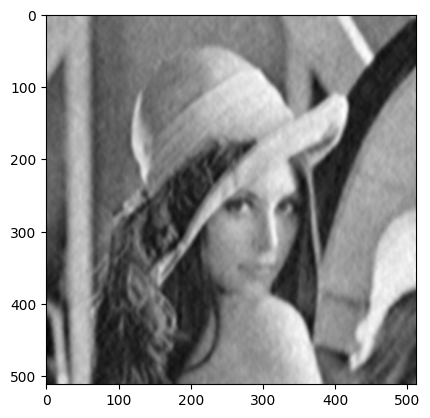

In [222]:
z = im - nu
plt.imshow(z, cmap="gray")
plt.show()


Find the sparse optimal x


In [223]:
c = A.T(nu)

# find optimal x
x = A.T(z)
nnzix = ((gamma-np.abs(c))>=1e-3)
x[nnzix] = 0

# check primal optimal
imx = A.x(x)

primal_optimal = 1/2*np.linalg.norm(im - imx, 'fro')**2 + gamma * np.linalg.norm(np.ravel(x), 1)
dual_optimal = np.dot((1/2*nu - im).reshape(-1),nu.reshape(-1))

print(primal_optimal)
print(-dual_optimal)

809.3648605107536
809.3651178996126


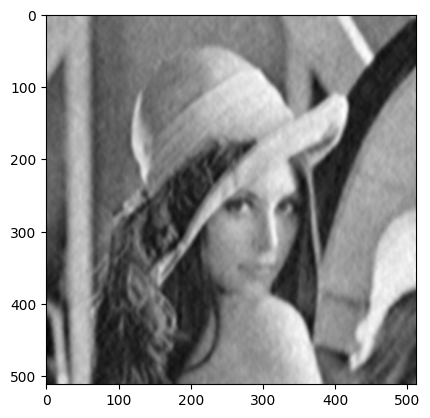

In [224]:
plt.imshow(imx, cmap="gray")
plt.show()

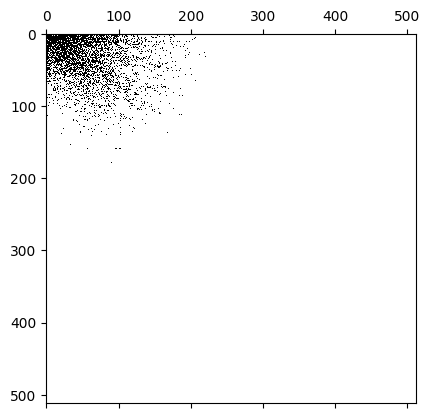

In [225]:
# Visualize the spare transformed coefficients x
plt.spy(x)